# Malaria Detektering

Denne journaler baseret på National Institute of Healths (NIH) officielle Malaria dataset:
https://ceb.nlm.nih.gov/repositories/malaria-datasets/. 

Datasettet indeholder 27.558 billeder af celler, hvoraf halvdelen er sunde celler og den anden halvdel er smittede celler. Vi fandt dette dataset på Kaggle, hvor vi valgte dette og besluttede os for, at bygge en form for Malaria detektering der kan skelne mellem sunde og smittede celler.

Et dataset på 27.558 billeder er som sådan, ikke særligt stort. Data augmentation (øge mængden af data), kunne derfor være spændende at lege med. Udover at data augmentation er oplagt at bruge når man har en forholdsvis lille datamængde, forhindrer det desuden modellen i at se det præcis samme billede flere gange.
I første omgang fortsætter vi dog uden, for muligvis at vende tilbage, hvis resultatet ikke blev godt nok og i såfald, forhåbentligt påvise en positiv forskel.

Vi har i denne opgave forsøgt at gå frem efter fremgangsmåden i HOML, chapter 2:
- Få dataet
- Undersøg og visualiser dataen for at få indsigt
- Forbered dataen til Machine Learning algoritmer
- Lav et test set
- Udvælg og træn en model
- Optimer modellen

# Få dataet

In [21]:
# Imports og From
import os
import cv2
import pandas as pd
import numpy as np
import keras

from pylab import *
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from keras.utils import np_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Activation, Dropout
from keras.models import Sequential
from keras import optimizers

# Til GPU cluster
from libitmal import kernelfuns as itmalkernelfuns
itmalkernelfuns.EnableGPU()

print('ok')

ok


In [ ]:
# Downloader og udpakker.
# Kun nødvendigt i første run
!wget = https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip 
!unzip cell_images.zip

Vi har nu downloaded og udpakket datasettet og fortsætter nu med at definere deres path i to variabler.

In [2]:
parasitized = os.listdir('/home/itmalgrp04/cell_images/Parasitized')
uninfected = os.listdir('/home/itmalgrp04/cell_images/Uninfected')

#parasitized = os.listdir('/Users/oscarp/Documents/Malaria_J3/cell_images/Parasitized')
#uninfected = os.listdir('/Users/oscarp/Documents/Malaria_J3/cell_images/Uninfected')

# Undersøg og visualiser  dataen for at få indsigt

For at bedre forstå forskellen mellem sunde (Uninfected) og smittede (Parasitized) celler, vil vi plotte 10 af billeder af hhv. 5 Uninfected og 5 Parasitized celler.

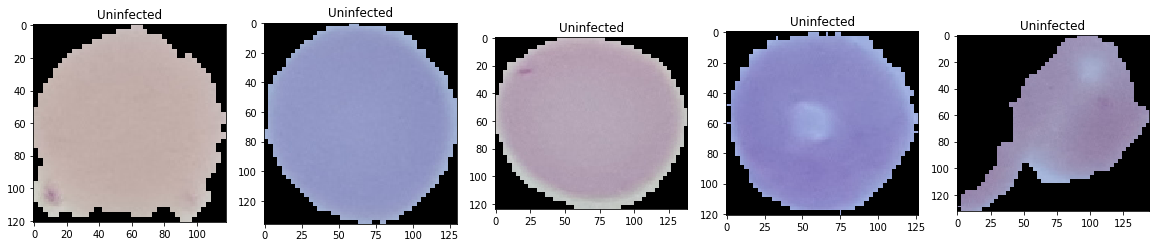

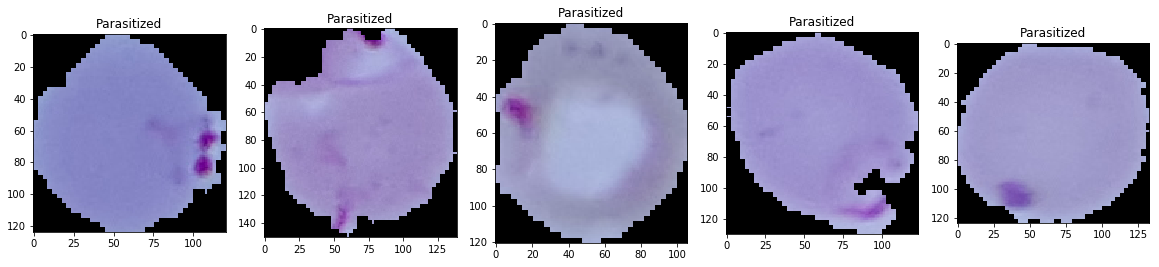

In [3]:
plt.figure(figsize = (20,20))
# Loop til at plotte 5 billeder af sunde celler
for i in range(5):
    plt.subplot(1, 5, i+1)
    #img = cv2.imread('/Users/oscarp/Documents/Malaria_J3/cell_images/Uninfected' + "/" + uninfected[i+1])
    img = cv2.imread('/home/itmalgrp04/cell_images/Uninfected' + "/" + uninfected[i+1])

    plt.title('Uninfected')
    plt.imshow(img)
plt.show()

plt.figure(figsize = (20,20))
# Loop til at plotte 5 billeder af smittede celler
for i in range(5):
    plt.subplot(1, 5, i+1)
    #img = cv2.imread('/Users/oscarp/Documents/Malaria_J3/cell_images/Parasitized' + "/" + parasitized[i])
    img = cv2.imread('/home/itmalgrp04/cell_images/Parasitized' + "/" + parasitized[i])

    plt.title('Parasitized')
    plt.imshow(img)
plt.show()

Kigger vi efter på plottene ovenover er det tydeligt at se, at billederne ikke skalerer på samme måde. Dette kunne ende ud i problemer senere. For at fikse dette, skal alle billederne skaleres på præcis samme måde. Næste punkt er derfor "Data Preparation".

# Forbered dataen til Machine Learning algoritmer
Her vil vi oprette data og labels lister. Data listen vil blive brugt til at indeholde de nyligt konverterede billeder. Labels listen vil indeholde hhv 1 og 0 for de to klasser (Parasitized og Uninfected).

In [4]:
labels = []
data = []

for img in parasitized:
    try:
        # Indlæser billede
        #img_read = plt.imread('/Users/oscarp/Documents/Malaria_J3/cell_images/Parasitized' + "/" + img)
        img_read = plt.imread('/home/itmalgrp04/cell_images/Parasitized' + "/" + img)

        # Tilpasser størrelsen efter egne specifikationer
        img_resize = cv2.resize(img_read, (50, 50))
        # Konverterer et PIL image til et Numpy array
        img_array = img_to_array(img_resize)
        # Adder til labels listen. Værdi 1 når Parasitized. I næste section er det værdien0, når Uninfected
        labels.append(1)
        # Adder til data listen
        data.append(img_array)
    except:
        None
        
        # Gentages for de sunde celler
for img in uninfected:
    try:
        #img_read = plt.imread('/Users/oscarp/Documents/Malaria_J3/cell_images/Uninfected' + "/" + img)
        img_read = plt.imread('/home/itmalgrp04/cell_images/Uninfected' + "/" + img)

        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        labels.append(0)
        data.append(img_array)
    except:
        None

In [5]:
# Assigner array med data og labels til nye variabler
Cells = np.array(data)
Labels = np.array(labels)

In [6]:
# Får dimensionerne af arrayet og blander dem.
a = np.arange(Cells.shape[0])
np.random.shuffle(a)
Cells = Cells[a]
Labels = Labels[a]

# Lav et test set
I nedenstående afsnit påbegynder vi et Train/test split af vores dataset på 20%. 

In [7]:
# Train/test split på 20% og med random_state parameter
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(Cells, Labels, test_size = 0.2, random_state = 42)

Da vores classifier har flere klasser (N=2), vil det sidste output lag i vore Neurale netværk have to neuroner, en for hver klasse. Her vil One Hot Encoding hjælpe os med, at ændre vores labels i binær format. 

Dette kunne også gøres i vores data augmentation, ved at sætte class_mode til "categorical", men i første omgang prøver vi som sagt uden data augmentation.

In [8]:
# One Hot Encoding på både vores train og test set.

y_train = np_utils.to_categorical(y_train,2)
y_test = np_utils.to_categorical(y_test,2)

# Print for overblik
print("Training data:",x_train.shape, "Training labels:", y_train.shape)
print("Test data:", x_test.shape, "Test labels:", y_test.shape)


Training data: (22046, 50, 50, 3) Training labels: (22046, 2)
Test data: (5512, 50, 50, 3) Test labels: (5512, 2)


Af ovenstående print kan vi konkludere, at vi med success har fået oprettet et Train/test med 20%. 
Output at printet skal forstås på følgende måde:

Training data: (22046, 50, 50, 3)
- Det første tal er antallet af billeder.
- Det andet og tredje tal er length og width på billedet. Dette definerede vi højere oppe da vi preparerede vores data
- Det fjerde og sidste tal er 3, og er dette da vi har et 3-kanals RGB billede

Training labels: (22046, 2)
- Det første tal er igen antallet af billeder.
- Det sidste tal er antallet af klasser: Parasitized & Uninfected

# Udvælg og træn en model

Næste step vil nu være at bygge vores Convolutional Neural Network (CNN) model. CNN er i særdeleshed kendetegnet ved at være fordelagtigt at bruge til billedgenkendelse, billed klassifikation og lignende. En CNN klassifikations model som denne vi gerne vil bygge, fungerer ved, at tage et input billede, processere det og klassificere det i en bestemt kategori (Parasitized eller Uninfected). Helt konkret bliver hvert billede sendt igennem en række Convolution layers med diverse filtre, en form for Pooling og til sidst tilføjer vi en Softmax funktion til at klassificere et billede med en værdi mellem 0 og 1.

Kigger vi nedenstående block, ses vores CNN model.
Her køres der med tre Convulution layers (Conv2D). 
- Den første parameter er antallet af filtre, der stiger i takt med dybden af netværket. Vores tre Conv2D lag er derfor med 16, 32 og 64 filtre.
- Det andet parameter siger noget om størrelser af disse convolution filtre. en kernel_size på 2 er her lig med 2x2.
- Den næste parameter er padding="same", der bibeholder vores spatiale volume, forstået på måde, at vores output størrelse matcher vores input størrelse. 
- Som activation funktionfaldt valget på reLU (Rectified Linear Unit). 
- Den sidste parameter i vores første lag er width, height, channels.

Efter hvert Conv2D lag, tilføjer vi en MaxPooling2D funktion. Dette gøres for at down-sample, og derved bliver output mindre end input. At vi har valgt MaxPooling from for f.eks. AveragePooling betyder helt konkret, at vi i det 2D input vindue vælger de maksimale værdier til at være vores output.

Vi tilføjer nu et Dropout lag for at forebygge overfitting. Dette gøres ofte hvis netværket er for stort, hvis man træner for længe eller evt. ikke har nok data.

Da vi gerne vil benytte denne data i et neuralt netværk, flader vi dataen ud fra et map til en kolonne, groft beskrevet.

Der følger nu en række dense og dropout lag der fungerer som vores fully-connected layers. I sidste lag benyttes der activation="softmax", idet vi gerne vil have outputtet en probability på mellem 0 og 1. Som tidligere nævnt, er Softmax derfor helt oplagt til multi-klassifikation.


In [9]:
#CNN model uden data augmentation
# https://keras.io/layers/convolutional/
from sklearn.naive_bayes import MultinomialNB

#Laver den til en function så den kan genbruges
def CNN(height, width, classes, channels):
    
    model=Sequential()
    model.add(Conv2D(filters=16,
                 kernel_size=2,
                 padding="same",
                 activation="relu",
                 input_shape=(50,50,3)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32,
                 kernel_size=2,
                 padding="same",
                 activation="relu"))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64,
                 kernel_size=2,
                 padding="same",
                 activation="relu"))
    model.add(MaxPooling2D(pool_size=2))

    # For at undgå overfitting
    model.add(Dropout(0.5))
    # Flader ud så kan benyttes senere
    model.add(Flatten())
    model.add(Dense(750,activation="relu"))
    model.add(Dropout(0.5))

    # Softmax var det naturlige valg, da vi har mere end én klasse af klassificere, hvor sigmoid måske
    # er mere rettet mod binære. 2 er outpay layer neuroner
    model.add(Dense(2,activation="softmax"))
    return model

model = CNN(50, 50, 2, 3)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
__________

Ifht. valget af optimizer faldet vi over en artikel der sammenlignede de forskellige optimizers:
https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/

Denne viste, at Adam ville være et glimrende valg til vores formål, så vi startede med denne:

In [10]:
# Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc','mse'])
m = model.fit(x_train,y_train,batch_size=50,epochs=20, validation_data=(x_test, y_test),verbose=1)

Train on 22046 samples, validate on 5512 samples
Epoch 1/20
22046/22046 [==============================] - 3s 158us/step - loss: 0.4064 - acc: 0.8069 - mean_squared_error: 0.1296 - val_loss: 0.1663 - val_acc: 0.9508 - val_mean_squared_error: 0.0420
Epoch 2/20
22046/22046 [==============================] - 3s 127us/step - loss: 0.1690 - acc: 0.9469 - mean_squared_error: 0.0437 - val_loss: 0.1590 - val_acc: 0.9514 - val_mean_squared_error: 0.0404
Epoch 3/20
22046/22046 [==============================] - 3s 121us/step - loss: 0.1509 - acc: 0.9543 - mean_squared_error: 0.0384 - val_loss: 0.1416 - val_acc: 0.9550 - val_mean_squared_error: 0.0364
Epoch 4/20
22046/22046 [==============================] - 3s 117us/step - loss: 0.1413 - acc: 0.9561 - mean_squared_error: 0.0366 - val_loss: 0.1432 - val_acc: 0.9541 - val_mean_squared_error: 0.0366
Epoch 5/20
22046/22046 [==============================] - 3s 118us/step - loss: 0.1368 - acc: 0.9566 - mean_squared_error: 0.0358 - val_loss: 0.1490 - 

In [11]:
#Evaluerer modellen på test data
evaluation = model.evaluate(x_test, y_test, verbose=1)
print("Eval Accuracy:",evaluation[1], "Eval loss:", evaluation[0])

5512/5512 [==============================] - 0s 57us/step
Eval Accuracy: 0.9608127721335269 Eval loss: 0.13805557394411053


In [12]:
# Opretter Klassifikations rapport (Performance Metric)
LabelPredict = model.predict(x_test,batch_size=50, verbose=1)
print(classification_report(y_test, np_utils.to_categorical(LabelPredict.argmax(axis=1),2))) 

5512/5512 [==============================] - 0s 41us/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2755
           1       0.96      0.96      0.96      2757

   micro avg       0.96      0.96      0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512
 samples avg       0.96      0.96      0.96      5512



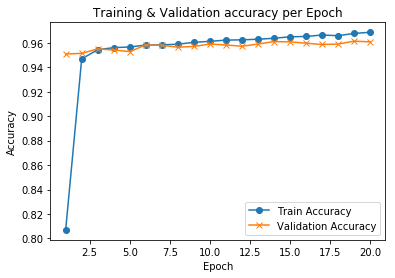

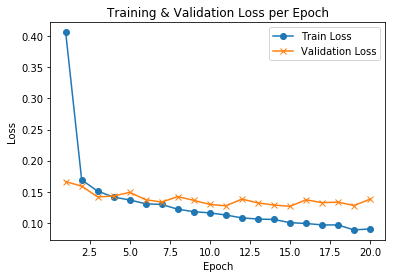

In [13]:
# Plotter data for bedre visuel forståelse

#Accuracy
a, ax = plt.subplots()

ax.set_title('Training & Validation accuracy per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.plot([None] + m.history['acc'], 'o-')
ax.plot([None] + m.history['val_acc'], 'x-')
ax.legend(['Train Accuracy', 'Validation Accuracy'])

#Loss
b, ax = plt.subplots()

ax.set_title('Training & Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot([None] + m.history['loss'], 'o-')
ax.plot([None] + m.history['val_loss'], 'x-')
ax.legend(['Train Loss','Validation Loss'], loc = 0)

# Optimer modellen

## SGD Optimizer

Da CNN er blevet defineret som en funktion, er det nemt at udskifte optimizeren uden for meget redundant kode. I nedenstående blok, er der forsøgt med en SGD optimizer uden specielle parametre.

Train on 22046 samples, validate on 5512 samples
Epoch 1/20
22046/22046 [==============================] - 2s 99us/step - loss: 0.6881 - acc: 0.5446 - val_loss: 0.6680 - val_acc: 0.5918
Epoch 2/20
22046/22046 [==============================] - 2s 96us/step - loss: 0.6670 - acc: 0.6001 - val_loss: 0.6667 - val_acc: 0.5911
Epoch 3/20
22046/22046 [==============================] - 2s 97us/step - loss: 0.6408 - acc: 0.6395 - val_loss: 0.6057 - val_acc: 0.6551
Epoch 4/20
22046/22046 [==============================] - 2s 102us/step - loss: 0.6081 - acc: 0.6788 - val_loss: 0.5696 - val_acc: 0.7046
Epoch 5/20
22046/22046 [==============================] - 2s 102us/step - loss: 0.5628 - acc: 0.7372 - val_loss: 0.5053 - val_acc: 0.7852
Epoch 6/20
22046/22046 [==============================] - 2s 102us/step - loss: 0.4980 - acc: 0.8094 - val_loss: 0.4204 - val_acc: 0.8500
Epoch 7/20
22046/22046 [==============================] - 2s 102us/step - loss: 0.4043 - acc: 0.8713 - val_loss: 0.3262 - val_

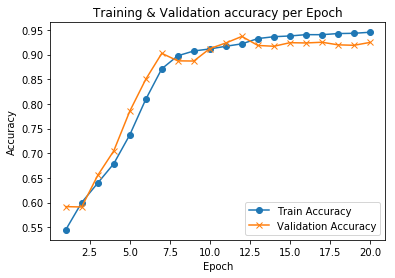

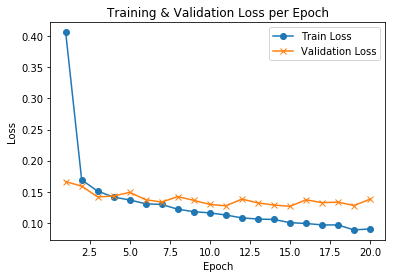

In [14]:
#Test med forskellige optimizers

model_SGD = CNN(50,50,2,3)
model_SGD.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['acc'])

m_SGD = model_SGD.fit(x_train,y_train,batch_size=50,epochs=20, validation_data=(x_test, y_test),verbose=1)

a, ax = plt.subplots()

ax.set_title('Training & Validation accuracy per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.plot([None] + m_SGD.history['acc'], 'o-')
ax.plot([None] + m_SGD.history['val_acc'], 'x-')
ax.legend(['Train Accuracy', 'Validation Accuracy'])

b, ax = plt.subplots()

ax.set_title('Training & Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot([None] + m.history['loss'], 'o-')
ax.plot([None] + m.history['val_loss'], 'x-')
ax.legend(['Train Loss','Validation Loss'], loc = 0)

LabelPredict = model_SGD.predict(x_test,batch_size=50, verbose=1)
print(classification_report(y_test, np_utils.to_categorical(LabelPredict.argmax(axis=1),2))) 

## SGD Optimizer with tuned parameters

Vi gentager nu med en SGD Optimizer, men benytter denne gang Keras anbefalede parametre (learning rate, momentum, nesterov mm.)

Train on 22046 samples, validate on 5512 samples
Epoch 1/20
22046/22046 [==============================] - 2s 102us/step - loss: 0.5594 - acc: 0.7045 - val_loss: 0.2934 - val_acc: 0.9169
Epoch 2/20
22046/22046 [==============================] - 2s 106us/step - loss: 0.2320 - acc: 0.9275 - val_loss: 0.2110 - val_acc: 0.9302
Epoch 3/20
22046/22046 [==============================] - 2s 106us/step - loss: 0.1708 - acc: 0.9469 - val_loss: 0.1706 - val_acc: 0.9434
Epoch 4/20
22046/22046 [==============================] - 2s 106us/step - loss: 0.1566 - acc: 0.9527 - val_loss: 0.1640 - val_acc: 0.9472
Epoch 5/20
22046/22046 [==============================] - 2s 106us/step - loss: 0.1498 - acc: 0.9547 - val_loss: 0.1504 - val_acc: 0.9508
Epoch 6/20
22046/22046 [==============================] - 2s 104us/step - loss: 0.1432 - acc: 0.9553 - val_loss: 0.1573 - val_acc: 0.9476
Epoch 7/20
22046/22046 [==============================] - 2s 101us/step - loss: 0.1399 - acc: 0.9564 - val_loss: 0.1632 - v

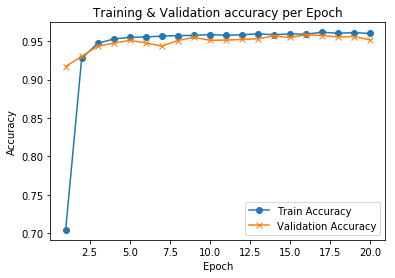

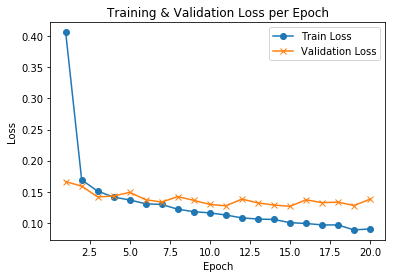

In [15]:
#Test med forskellige optimizers

model_SGD_Param = CNN(50,50,2,3)

sgdParam = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_SGD_Param.compile(loss='categorical_crossentropy', optimizer=sgdParam, metrics=['acc'])

m_SGD_Param = model_SGD_Param.fit(x_train,y_train,batch_size=50,epochs=20, validation_data=(x_test, y_test),verbose=1)

a, ax = plt.subplots()

ax.set_title('Training & Validation accuracy per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.plot([None] + m_SGD_Param.history['acc'], 'o-')
ax.plot([None] + m_SGD_Param.history['val_acc'], 'x-')
ax.legend(['Train Accuracy', 'Validation Accuracy'])

b, ax = plt.subplots()

ax.set_title('Training & Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot([None] + m.history['loss'], 'o-')
ax.plot([None] + m.history['val_loss'], 'x-')
ax.legend(['Train Loss','Validation Loss'], loc = 0)

LabelPredict = model_SGD_Param.predict(x_test,batch_size=50, verbose=1)
print(classification_report(y_test, np_utils.to_categorical(LabelPredict.argmax(axis=1),2))) 

## Nadam optimizer

I næste blok tester vi med Nadam optimizeren. I modsætning til Adam optimizeren der i bund og grund er en RMSprop med momentum, er Nadam en Adam RMSprop med Nesterov momentum. Denne vil vi nu teste med Kera dokumentationens officielle parametre.

Train on 22046 samples, validate on 5512 samples
Epoch 1/20
22046/22046 [==============================] - 3s 132us/step - loss: 0.5381 - acc: 0.7122 - val_loss: 0.1675 - val_acc: 0.9407
Epoch 2/20
22046/22046 [==============================] - 3s 153us/step - loss: 0.1644 - acc: 0.9484 - val_loss: 0.1464 - val_acc: 0.9559
Epoch 3/20
22046/22046 [==============================] - 3s 130us/step - loss: 0.1475 - acc: 0.9543 - val_loss: 0.1434 - val_acc: 0.9565
Epoch 4/20
22046/22046 [==============================] - 3s 122us/step - loss: 0.1399 - acc: 0.9565 - val_loss: 0.1454 - val_acc: 0.9566
Epoch 5/20
22046/22046 [==============================] - 3s 126us/step - loss: 0.1364 - acc: 0.9560 - val_loss: 0.1400 - val_acc: 0.9543
Epoch 6/20
22046/22046 [==============================] - 3s 126us/step - loss: 0.1296 - acc: 0.9581 - val_loss: 0.1322 - val_acc: 0.9585
Epoch 7/20
22046/22046 [==============================] - 3s 126us/step - loss: 0.1270 - acc: 0.9596 - val_loss: 0.1318 - v

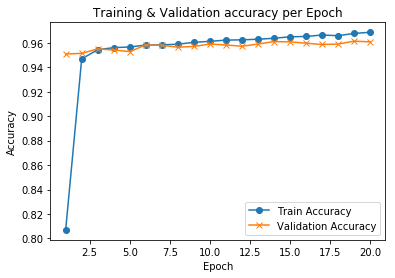

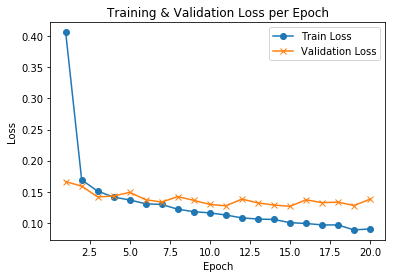

In [16]:
#Test med forskellige optimizers
model_Nadam = CNN(50,50,2,3)

nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
model_Nadam.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['acc'])

m_Nadam = model_Nadam.fit(x_train,y_train,batch_size=50,epochs=20, validation_data=(x_test, y_test),verbose=1)

#Accuracy
a, ax = plt.subplots()
ax.set_title('Training & Validation accuracy per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.plot([None] + m.history['acc'], 'o-')
ax.plot([None] + m.history['val_acc'], 'x-')
ax.legend(['Train Accuracy', 'Validation Accuracy'])

#Loss
b, ax = plt.subplots()
ax.set_title('Training & Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot([None] + m.history['loss'], 'o-')
ax.plot([None] + m.history['val_loss'], 'x-')
ax.legend(['Train Loss','Validation Loss'], loc = 0)

LabelPredict = model_Nadam.predict(x_test,batch_size=50, verbose=1)
print(classification_report(y_test, np_utils.to_categorical(LabelPredict.argmax(axis=1),2))) 

In [17]:
# Plotter confusion matrix:

import sklearn.metrics as metrics
LabelPredict1 = model_Nadam.predict(x_test,batch_size=50, verbose=1)
print(metrics.confusion_matrix(y_test.argmax(axis=1), LabelPredict1.argmax(axis=1)))

5512/5512 [==============================] - 0s 38us/step
[[2676   79]
 [ 150 2607]]


# Performance Metrics

I løbet af hele projektet har vi ved hver ny optimizer løbende plottet grafer og Classification_Reports indeholdende Precision, Recall samt F1. Disse er ikke blevet forklaret og diskuteret endnu, men vil nu blive gjort. 

Overordnet set er der fire måder at se om hvorvidt vores predictions er korrekte:
1. TN/True Negative: Når en case er negativ og er predicted negativt.
2. TP/True Positive: Når en case positiv og er predicted positivt.
3. FN/False Negative: Når en case er positiv men blev predicted negativ.
4. FP/False Positive: Når en case er negativ men blev predicted positiv. 

## Precision
Precision er en metrics der siger noget om hvor mange procent af ens predictions der var korrekte.
Man kan derfor sige, at precision er den egenskab at en classifier ikke labeler noget positivt der rent faktisk skulle være negativt. 
Dette defineres således: Precision = TP/(TP+FP)

## Recall
Recall definerer hvor stor en procentdal af de positive cases man opdagede. Med dette menes der, at det er den egenskab at classifieren finder alle positive instanser. Dette kan defineres på følgende måde:
Recall = TP/(TP+FN)

## F1 Score
F1 score er den vægtede middelværdi af precision og recall, forstået således at den bedste score er 1.0 og det absolut værste er 0.0. F1 score defineres på følgende måde:
F1Score = 2*(Recall*Precision)/(Recall+Precision)

## Confusion Matrix
En Confusion Matrix er endnu en performance metric der ofte blive brugt til at bedømme klassifikations algoritmer.
Lad os kigge på den ovenover printede Confusion Matrix:

- [2751   69]     [TP FP]
- [160  2532]     [FN TN]

På vores x-akse har vi de reele data og på vores y-akse de predicted data.
Med denne viden, kan man derfor hurtigt danne sig et overblik over forholdet mellem Precision, recall samt helt overordnet hvorvidt ens model er god.


# Diskussion

På trods af en relativ simpel opbygning, lykkedes os at træne en glimrende Malaria classifier der kan skelne mellem sunde og inficerede celler med en sandsynlighed på mellem 94.54-96.87%, afhængig af optimizeren. Vi havde i første omgang forventet, at vi blev nødsat til at benytte data augmentation, da vores dataset ikke var så stort. Dette blev dog ikke nødvendigt!

Ved at sammenligne plottene, classification_reports samt confusion matrix, kan vi sammenfatte resultaterne af de forskellige optimizers.

Efter at have læst den tidligere beskrevet artikel, startede vi med Adam optimizeren, der faktisk gav os den bedste Accuray og loss på hhv. 0.9687 og 0.0902. 
<br>
<img src="Adam.png" style="width: 300px;"/>
<img src="AdamClass.png" style="width: 300px;"/>
<br>
Vi fortsatte dernæst med SGD optimizeren. Her fik vi en accuracy og loss på 0.9453 og 0.1722. Dette var faktisk opgavens dårligste resultat efter 20 epochs. Det spændende ved SGD var dog, at den var noget langsommere til at nå de 0.90. Vi kan desuden konkludere ud fra vores classification_report, at der var problemer med precision og recall, hvilket resulterede i de laveste F1 scores i projektet.
<br>
<img src="SGD.png" style="width: 300px;"/>
<img src="SGDClass.png" style="width: 300px;"/>
<br>

Den næste testede optimzer var igen SGD, men nu tunede parametre såsom learning rate, momentum og nesterov. Med disse parametre så vi nu en langt hurtigere model, der nåede +0.090 allerede efter anden EPOCH. Accuracy og loss lå på hhv. 0.9598 og 0.1183. Denne model opnåede desuden også testens højeste peak i precision og recall, men en lavere F1 score end Adam optimizeren.
<br>
<img src="SGDparam.png" style="width: 300px;"/>
<img src="SGDparamClass.png" style="width: 300px;"/>
<br>

Den sidste testede optimizer mindede på mange måder om Adam optimizeren, idet Nadam i bund og grund er en Adam optimizer med Nesterov momentum. Accuracy og loss landede på 0.9657 og 0.1001, og var dermed tæt på at være den bedste i projektet. Nadams classification report matchede desuden Adams report med en F1 score på 0.96.
<br>
<img src="Nadam.png" style="width: 300px;"/>
<img src="NadamClass.png" style="width: 300px;"/>
<br>
Alt i alt er vi i gruppen nogenlunde tilfredse med resultaterne. Vi har op til deadline desværre alle været meget pressede grundet bachelor, ITMAL samt ROB2 afleveringer, alle inden for den samme uge. Dette har betydet, at vi ikke har haft overskudet til at gå den ekstra mil og undersøge andre spændende muligheder. 

# Arbejdsfordeling
Vi har i løbet af J1 og J2 desværre været dårlige til at sidde og få lavet ugens opgaver til forelæsningen. Dette endte ud med at "straffe" os lidt i form af nogle lange dage op til de to deadlines. Vi besluttede derfor til J3, at sidde og arbejde sammen på skolen, hver gang vi havde ITMAL. Dette betyder derfor også, at alle parter har været inde over langt de fleste dele af opgaven. Vi mener at dette er en styrke, da vi derfor alle sammen har opnået en bredere forståelse omkring projektet som helhed

# Personlige konklusioner

## Oscar Ohrt Pradel

Jeg har virkelig syntes om dette J3 projektet og været glad for, at vi har haft så frie muligheder for selv at vælge et spændende og derved motiverende projekt. At vi tog udgangspunkt i den overordnede framgangsmåde i HOML chapter 2, syntes jeg, var med til at danne en god grundstruktur og plan for projektets opbygning.
De frie muligheder for J3, gav mig heldigvis muligheden for at nørde rundt i Convolutional Neural Network i Keras. Specielt CNNs Convolutional layers har været spændende at undersøge mere grundigt og jeg har f.eks. fået tilegnet mig en solid grundlæggende viden omkring activation layers og hvornår f.eks. "reLU" er at foretrække from for "tanh". Dette havde jeg kun sparsom viden omkring efter J2, men omfanget og tiden brugt på dette projekt, tillod mig at dykke i bunds med det.
<br>
Jeg var ærlig talt imponeret over den performance vi fandt frem til. Det var især interessant at observere hvordan de forskellige optimizers performede på vores CNN, og i særdeleshed hvordan SGD var en del langsommere end de andre optimizere.
Med udgangspunkt i den relativt lille mænge data vi havde til rådighed, havde vi i første omgang diskuteret nødvendigheden af, at benytte en form for data augmentation til at øge vores datamængde. Dette ved at flippe, rotere og zomme på vores dataset. Dette blev dog ikke aktuelt, da vores resultater viste sig at være fyldestgørende.
<br>
<br>
Igennem projektet har det været godt, at vi har haft adgang til GPU-clusteren. Omend vores dataset ikke er enormt, har det til tider krævet lang tid at processere på vores egne pc'er. 
Havde vi ikke været pressede med andre fag, ville det desuden have været super spændende at experimentere med en pretrained VGG-19 model eller noget ResNET og eventuelt tilføje data augmentation. Der er en enorm verden af muligheder derude og med de store mængder velskrevet dokumentation, er det bare at give det et skud og prøve sig frem.

 

## Andreas Blaabjerg

Personligt er jeg rigtig tilfreds, med det arbejde vi har lagt i denne opgave. Det er lidt en øjenåbner for hvad machine learning kan anvendes til. Jeg må indrømme, at jeg føler kurset var lidt autopilot-agtigt, i de første to journaler, fordi man bare følger en støbt problemformulering. Men når man ser tilbage fra denne opgave, har de været en total nødvendighed, for bare at få fingrene i det fra starten af.
<br>
Selve optimeringen af modellen med Adam, SGD var spændende at arbejde med, især at se en radikal ændring i learning rate, efter indførelsen af de tunede parametre fra Keras. Så kan man noget nemmere forholde sig til begreberne ud fra vores egne data. At vi valgte at arbejde med billedgenkendelse, har vist sig at give pote, da det er rigtigt spændene at tænke videre, hvordan man ellers kan anvende denne teknologi, men på en virksomhedsbasis, hvor kun fantasien sætter grænser. Virkelig fedt at skabe sig en fornemmelse for hvad der rent faktisk er ’store dataset’ og hvor meget man kan træne div. Modeller. 
<br>
<br>
Yderligere var det et kæmpe drive at finde et projekt sammen med ens gruppe, da selve researchen af andres anvendelse af machine learning, giver et indblik i den vinkel man selv vil behandle et problem fra. Jeg føler selv, at jeg har rykket mig, indenfor for kursets rammer under de opgaver vi har arbejdet med.


## Stanisislav Lunderskov

Udfordringen har ligget i at vælge de rigtige metrics at måle performance af, så man kan kvalitetsanalysere og til sidst sikre løsningen. Det var nødvendig med flere  forskellige skulle tests på hele datasættet for at gøre målingen så nøjagtig som muligt. Med denne type valg, hvor man selv skal 'beregne' sin opgaves success-kriterier, frem for at løse et problem med lærerens definerede 'problemformulering', er processen yderst anderledes end man er vant til under uddannelsesforløbet, men et ekstremt interessant emne alt i alt. 
<br>
<br>
Personligt har jeg fået en bedre forståelse af meningen med Activations, hvordan og hvornår de skal bruges. Men også hvilken man skal bruge i det specifikke tilfælde. Denne forbedring af forståelsen er også på baggrund af at have fejlbrugt metoden i J1. Det har været stort drive i dette projekt, at løsningen faktisk er et real-life problem. Man kan overfør læringen fra dette fag til alverdens problemer, og forbedrer alle virtuelle systemer der allerede eksisterer. Jeg har personligt i hvert fald også lært forskellen mellem 'accuracy' og 'precision', samt en række af de andre datahånterings termer.
<br>
Det var overraskende hvor meget computerkraft alle de iterationer af algoritmen krævede, hvilket vi lærte at leve med, indtil vi tæt på deadline fandt ud af at bruge Orbit Labs supercomputer. Det satte virkelig tingene i perspektiv, især fordi dette datasæt er en af de 'mindre'. Yderligere, var det imponerende at ’Nadam optimizer’ med Keras dokumentationens officielle parametre, øgede præcisionen af resultatet så meget.


## Victor Mogharrabian Fard

Generelt har opgave J3 været lærerigt hvad image processing angår. Det var spændende at se hvordan det fungerer, når man skal skalere et reelt billede, inden data prep sker, i modsætning til de andre øvelser, hvor vi blandt andet har skullet arbejde med et MNIST sæt, som er håndskrevne tal. 
<br>
<br>
Data preparation var en vital komponent i denne opgave, da det fungerede som grundsten til resten af opgaven. Der er ikke vildt meget preparation, men følgende steps skulle foretages, inden nogen form for videre iteration kunne fortsættes, hvilket, personligt var det største udbytte for mig. Idéen om at et skaleret billede kan ødelægge resten af processen, og at man meget simpelt kan kategorisere forskellige typer data i et array, binært, var også brugbar viden for mig. 
En anden ting som var overraskende, var effektiviteten af de forskellige optimizers. 
SGD-optimizeren i sig selv havde en f1-score på 93% og 92% og med SGD-optimizeren med tuned parameters lå den på solide 95% begge steder. Det var overraskende hvad parametrene ”lr”, ”decay”, ”momentum” og ”nesterov” gjorde for f1-scoren af datasættet.
<br>
Det var dog mest imponerende da NADAM-optimizeren overskred f1-scores fra de forrige optimizers med solide 96% begge steder. Idéen bag at bruge optimizers har været ekstremt lærerigt for mig, i pågældende projekt og det bliver en solid forståelse for måden at træne datasæt på.



### Keras Dokumentation, CNN
https://keras.io/getting-started/sequential-model-guide/

### Keras Dokumentation, Optimizers
https://keras.io/optimizers/

### Performance Metrics
https://medium.com/thalus-ai/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b

### Data Preparation
https://developers.google.com/machine-learning/data-prep/transform/introduction